In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from loren_frank_data_processing import make_epochs_dataframe
from src.parameters import ANIMALS

epoch_info = make_epochs_dataframe(ANIMALS)
epoch_info

environment   type  exposure
animal day epoch                              
Roqui  2   1            sleep  sleep       NaN
           2      lineartrack    run       1.0
           3            sleep  sleep       NaN
           4      lineartrack    run       2.0
           5            sleep  sleep       NaN
           6       lineartack    run       1.0
           7            sleep  sleep       NaN
           8      lineartrack    run       3.0
           9            sleep  sleep       NaN
       5   1            sleep  sleep       NaN
           2           wtrack    run       1.0
           3            sleep  sleep       NaN
           4           wtrack    run       2.0
           5            sleep  sleep       NaN
           6           wtrack    run       3.0
           7            sleep  sleep       NaN
           8           wtrack    run       4.0
           9            sleep  sleep       NaN

In [4]:
epoch_key = ('Roqui', 5, 2)
epoch_key

('Roqui', 5, 2)

## Position Info

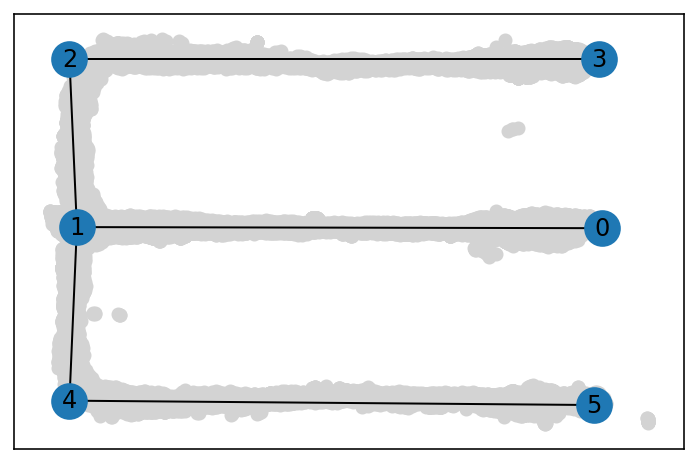

In [5]:
from loren_frank_data_processing.core import get_data_structure
from loren_frank_data_processing.position import make_track_graph, classify_track_segments
from loren_frank_data_processing.track_segment_classification import plot_track


def _get_pos_dataframe(epoch_key, animals):
    animal, day, epoch = epoch_key
    struct = get_data_structure(ANIMALS[animal], day, 'posdlc', 'posdlc')[epoch - 1]
    position_data = struct['data'][0, 0]
    FIELD_NAMES = ['time',
                   'x_position_nose_tail', 'y_position_nose_tail', 'velocity_nose_tail',
                   'x_position_nose', 'y_position_nose', 'velocity_nose',
                   'x_position_tail_base', 'y_position_tail_base', 'velocity_tail_base']
    time = pd.TimedeltaIndex(
        position_data[:, 0], unit='s', name='time')

    return pd.DataFrame(position_data, columns=FIELD_NAMES, index=time)


pos_df = _get_pos_dataframe(epoch_key, ANIMALS)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

plot_track(track_graph)
plt.scatter(pos_df.x_position_tail_base, pos_df.y_position_tail_base, color='lightgrey', zorder=-1)

position = pos_df.loc[:, ['x_position_tail_base', 'y_position_tail_base']].values

route_euclidean_distance_scaling = 1E5
sensor_std_dev = 25

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=route_euclidean_distance_scaling,
    sensor_std_dev=sensor_std_dev)

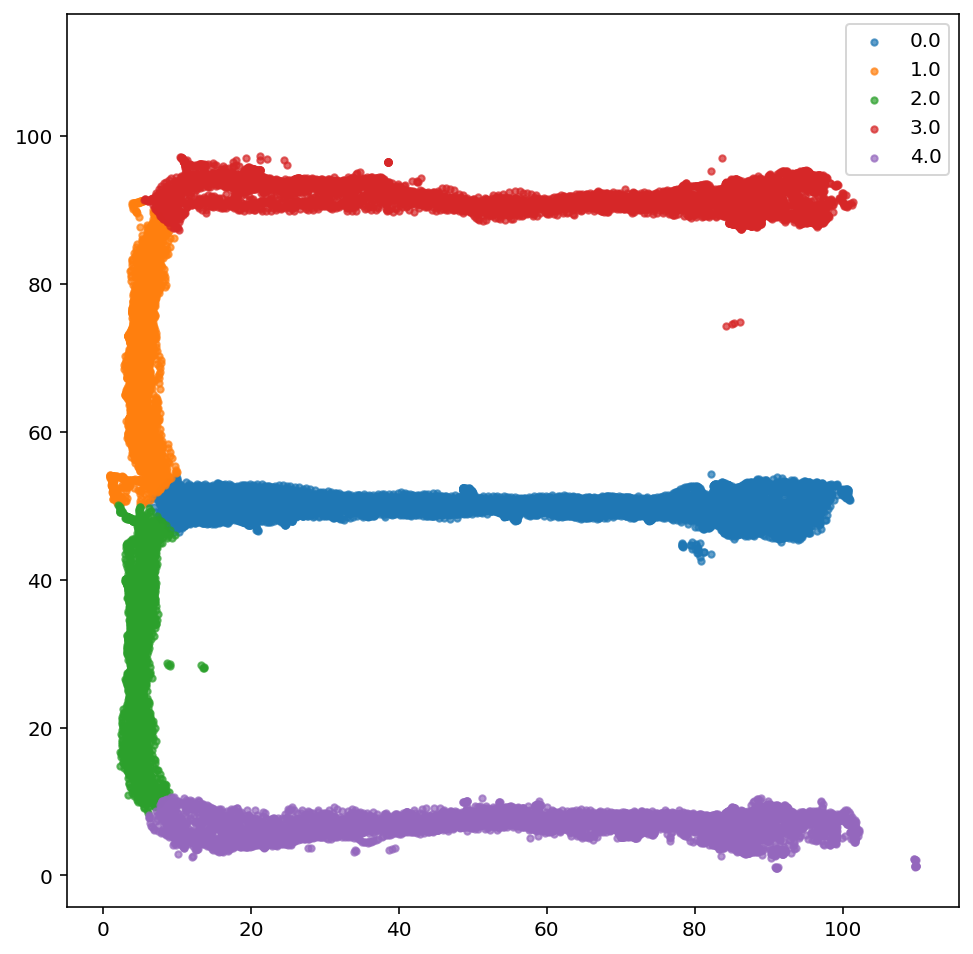

In [15]:
pos_df['track_segment_id'] = track_segment_id

fig, ax = plt.subplots(figsize=(8, 9))

for edge_label, df in pos_df.groupby('track_segment_id'):
    ax.scatter(df.x_position_tail_base, df.y_position_tail_base, s=10, alpha=0.7, label=edge_label)
plt.legend()
plt.axis('square');

In [7]:
from loren_frank_data_processing.track_segment_classification import calculate_linear_distance

linear_distance = calculate_linear_distance(
    track_graph, track_segment_id, center_well_id, position)

In [8]:
pos_df['linear_distance'] = linear_distance

In [9]:
def convert_linear_distance_to_linear_position(
        linear_distance, track_segment_id, edge_order, spacing=30):
    linear_position = linear_distance.copy()
    n_edges = len(edge_order)
    if isinstance(spacing, int) | isinstance(spacing, float):
        spacing = [spacing,] * (n_edges - 1)

    for prev_edge, cur_edge, space in zip(edge_order[:-1], edge_order[1:], spacing):
        is_cur_edge = (track_segment_id == cur_edge)
        is_prev_edge = (track_segment_id == prev_edge)

        cur_distance = linear_position[is_cur_edge]
        cur_distance -= cur_distance.min()
        cur_distance += linear_position[is_prev_edge].max() + space
        linear_position[is_cur_edge] = cur_distance

    return linear_position

In [10]:
EDGE_ORDER = [0, 1, 3, 2, 4]
EDGE_SPACING = [15, 0, 15, 0]

pos_df['linear_position'] = convert_linear_distance_to_linear_position(
    pos_df.linear_distance.values,
    pos_df.track_segment_id.values, EDGE_ORDER, spacing=EDGE_SPACING)

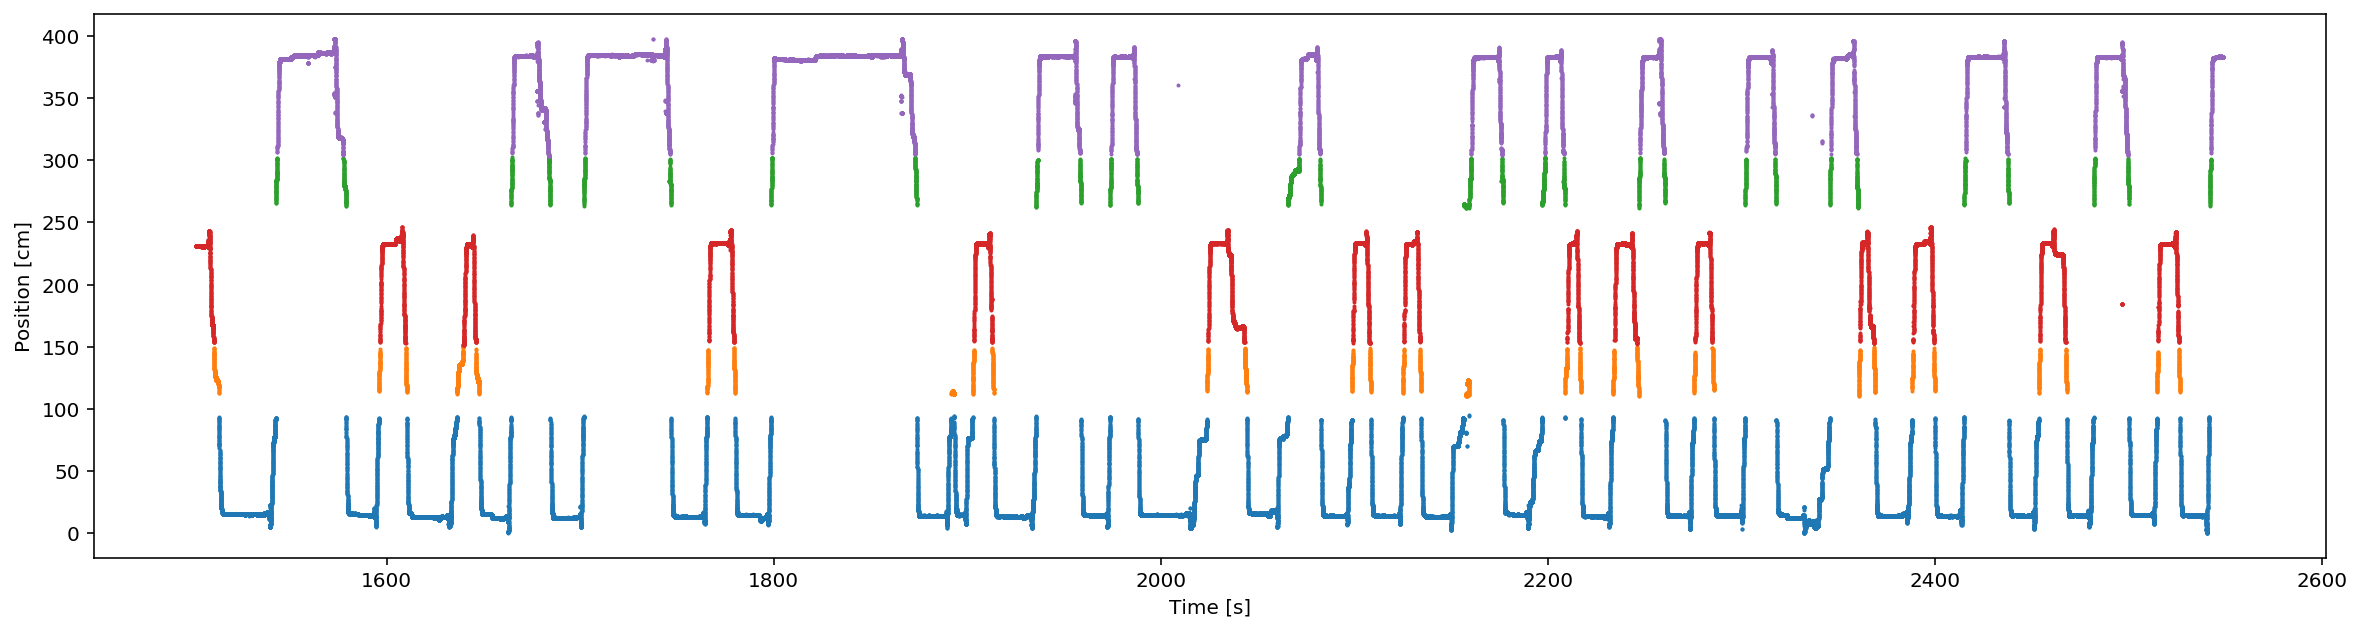

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))

for edge_label, df in pos_df.groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

# Multiunits

In [12]:
from loren_frank_data_processing import make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
tetrode_info

area deadchans depth  numcells suparea  \
animal day epoch tetrode_number                                              
Roqui  5   2     1                  ca1L        []    []         0     hpc   
                 2                  ca1L        []    []         0     hpc   
                 3                  ca1L         4    []         0     hpc   
                 4               ca1Lref        []    []         0      cc   
                 5                  ca1L        []    []         0     hpc   
                 6                  ca1L        []    []         0     hpc   
                 7                  ca1L        []    []         0     hpc   
                 8                  ca1L        []    []         0     hpc   
                 9                  ca1L        []    []         0     hpc   
                 10                 ca1L        []    []         0     hpc   
                 11                 ca1L        []    []         0     hpc   
                 12                 ca1L        []    []         0     hpc   
                 13                 ca1L        []    []         0     hpc   
                 14                 ca1L        []    []         0     hpc   
                 15                 ca1L        []    []         0     hpc   
                 16                 ca1R        []    []         0     hpc   
                 17                 ca1R        []    []         0     hpc   
                 18                 ca1R        []    []         0     hpc   
                 19                 ca1R        []    []         0     hpc   
                 20                 ca1R        []    []         0     hpc   
                 21                 ca1R        []    []         0     hpc   
                 22                 ca1R        []    []         0     hpc   
                 23                 ca1R        []    []         0     hpc   
                 24                 ca1R        []    []         0     hpc   
                 25                 ca1R        []    []         0     hpc   
                 26                 ca1R        []    []         0     hpc   
                 27              ca1Rref        []    []         0      cc   
                 28                 ca1R        []    []         0     hpc   
                 29                 ca1R        []    []         0     hpc   
                 30                 ca1R        []    []         0     hpc   
                 31                  NaN       NaN    []         0     NaN   
                 32                  NaN       NaN    []         0     NaN   

                                 tetrode       tetrode_id  
animal day epoch tetrode_number                            
Roqui  5   2     1                     1  Roqui_05_02_001  
                 2                     2  Roqui_05_02_002  
                 3                     3  Roqui_05_02_003  
                 4                     4  Roqui_05_02_004  
                 5                     5  Roqui_05_02_005  
                 6                     6  Roqui_05_02_006  
                 7                     7  Roqui_05_02_007  
                 8                     8  Roqui_05_02_008  
                 9                     9  Roqui_05_02_009  
                 10                   10  Roqui_05_02_010  
                 11                   11  Roqui_05_02_011  
                 12                   12  Roqui_05_02_012  
                 13                   13  Roqui_05_02_013  
                 14                   14  Roqui_05_02_014  
                 15                   15  Roqui_05_02_015  
                 16                   16  Roqui_05_02_016  
                 17                   17  Roqui_05_02_017  
                 18                   18  Roqui_05_02_018  
                 19                   19  Roqui_05_02_019  
                 20                   20  Roqui_05_02_020  
                 21                   21  Roqui_05_02_021  
   

In [13]:
from loren_frank_data_processing import get_all_multiunit_indicators

tetrode_keys = tetrode_info.loc[tetrode_info.area.isin(['ca1R', 'ca1l'])].index

position_info = pos_df.resample('2ms').mean().interpolate('time')

def _time_function(*args, **kwargs):
    return position_info.index

multiunits = get_all_multiunit_indicators(
    tetrode_keys, ANIMALS, _time_function)

In [14]:
multiunits.isel(tetrodes=1).dropna('time')

<xarray.DataArray (time: 105557, features: 4)>
array([[ 69., -26., -22.,  40.],
       [ 63.,  69.,  94.,  51.],
       [ 72.,  71., 121.,  46.],
       ...,
       [-18.,  32., 150., -18.],
       [ 15.,  33.,  75.,  -1.],
       [ 78.,   0.,   4.,  44.]])
Coordinates:
  * features  (features) <U13 'channel_1_max' ... 'channel_4_max'
  * time      (time) timedelta64[ns] 00:25:01.476544 ... 00:42:29.040544